### Importing libraries

In [531]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime as dt

### Importing data and basic exploration

In [534]:
# Importing dataset as dataframe
df = pd.read_csv('activities.csv')

In [536]:
# Quick look at the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 94 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Activity ID                   214 non-null    int64  
 1   Activity Date                 214 non-null    object 
 2   Activity Name                 214 non-null    object 
 3   Activity Type                 214 non-null    object 
 4   Activity Description          110 non-null    object 
 5   Elapsed Time                  214 non-null    int64  
 6   Distance                      214 non-null    object 
 7   Max Heart Rate                206 non-null    float64
 8   Relative Effort               206 non-null    float64
 9   Commute                       214 non-null    bool   
 10  Activity Private Note         0 non-null      float64
 11  Activity Gear                 0 non-null      float64
 12  Filename                      214 non-null    object 
 13  Athle

In [538]:
# Change columnn names to lower case
df.columns=df.columns.str.lower() 

In [540]:
# Since there are 94 columns, let's create a new dataframe only with columns meaningful for the analysis
cols = ['activity date', 'activity type', 'elapsed time',  'distance',   
         'average heart rate', 'moving time', 'max speed', 'average speed', 'calories', 'total steps'
       ]
df = df[cols] 

In [542]:
# The analysis concenrs only runs, so let's create a new dataframe
runs = df[df['activity type']=='Run']

In [544]:
runs = runs.copy()

### Missing values

In [547]:
# First let's find the number of missing values
runs.isnull().sum()

activity date          0
activity type          0
elapsed time           0
distance               0
average heart rate     2
moving time            0
max speed              0
average speed          0
calories              33
total steps            0
dtype: int64

#### calories

In [550]:
# There are 33 missing values in the 'calories' column, let's fill them out with calories burnt during runs with similar distance
def fill_calories_by_similar_distance(row, df, tolerance=0.25):
    if np.isnan(row['calories']):
        # znajdź podobne dystanse
        similar = runs[(runs['distance'] >= row['distance'] - tolerance) & 
                     (runs['distance'] <= row['distance'] + tolerance) & 
                     (runs['calories'].notna())]
        # jeśli są takie wiersze – zwróć ich średnią kalorii
        if not similar.empty:
            return similar['calories'].mean()
    return row['calories']

In [552]:
runs['distance'] = (runs['distance']).astype(float) 
runs['calories'] = runs.apply(lambda row: fill_calories_by_similar_distance(row, df), axis=1)

#### average heart rate

In [555]:
runs[runs['average heart rate'].isna()]

,activity date,activity type,elapsed time,distance,average heart rate,moving time,max speed,average speed,calories,total steps
74,"Nov 4, 2024, 2:37:04 PM",Run,2105,5.00,NaN,2055.0,3.45,2.433382,294.705882,5414.0
127,"Jan 29, 2025, 6:50:23 AM",Run,2026,5.15,NaN,1947.0,4.20,2.646585,294.705882,5390.0


In [557]:
# As there are only two rows with missing average heart rate, let's just drop them
runs = runs[~(runs['average heart rate'].isna())]

In [559]:
# Let's check if there are any missing values left
runs.isnull().sum()

activity date         0
activity type         0
elapsed time          0
distance              0
average heart rate    0
moving time           0
max speed             0
average speed         0
calories              0
total steps           0
dtype: int64

### Transforming data

#### activity date

In [604]:
# Breaking the activity date columns into time and date columns
runs['activity date'] = pd.to_datetime(runs['activity date'], format="mixed")
runs.info()

runs['day'] = runs['activity date'].dt.day
runs['month_name'] = runs['activity date'].dt.month_name()
runs['year'] = runs['activity date'].dt.year
runs['time'] = runs['activity date'].dt.time

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 3 to 213
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   activity date       109 non-null    datetime64[ns]
 1   activity type       109 non-null    object        
 2   elapsed time        109 non-null    float64       
 3   distance            109 non-null    float64       
 4   average heart rate  109 non-null    float64       
 5   moving time         109 non-null    float64       
 6   max speed           109 non-null    float64       
 7   average speed       109 non-null    float64       
 8   calories            109 non-null    float64       
 9   total steps         109 non-null    float64       
 10  day                 109 non-null    object        
 11  month_name          109 non-null    object        
 12  year                109 non-null    object        
 13  time                109 non-null    object        
 14 

,activity date,activity type,elapsed time,distance,average heart rate,moving time,max speed,average speed,calories,total steps,day,month_name,year,time,avg pace,rolling_avg_pace,cluster
3,2024-04-22 14:53:39,Run,26.2,2.6,120.7,26.2,4.2,1.7,135.0,3276.0,22,April,2024,14:53:39,10.0,10.000,1
2,2024-04-23 14:01:57,Run,30.1,3.1,121.4,30.1,4.1,1.7,165.0,3736.0,23,April,2024,14:01:57,9.8,9.900,1
1,2024-04-25 13:47:37,Run,30.0,3.0,125.8,30.0,3.2,1.7,162.0,3712.0,25,April,2024,13:47:37,9.9,9.900,1
0,2024-04-28 13:31:04,Run,30.0,3.0,125.9,30.0,3.0,1.7,150.0,3726.0,28,April,2024,13:31:04,10.0,9.925,1
4,2024-05-06 18:37:06,Run,30.1,3.0,136.1,30.1,3.1,1.7,176.0,3812.0,6,May,2024,18:37:06,9.9,9.920,1


In [565]:
# Changing year, day and activity date to object 
runs['year'] = (runs['year']).astype(object) 
runs['day'] = (runs['day']).astype(object) 
runs['activity date'] = (runs['activity date']).astype(object) 

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 0 to 213
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity date       109 non-null    object 
 1   activity type       109 non-null    object 
 2   elapsed time        109 non-null    int64  
 3   distance            109 non-null    float64
 4   average heart rate  109 non-null    float64
 5   moving time         109 non-null    float64
 6   max speed           109 non-null    float64
 7   average speed       109 non-null    float64
 8   calories            109 non-null    float64
 9   total steps         109 non-null    float64
 10  day                 109 non-null    object 
 11  month_name          109 non-null    object 
 12  year                109 non-null    object 
 13  time                109 non-null    object 
dtypes: float64(7), int64(1), object(6)
memory usage: 12.8+ KB


#### Elapsed time, moving time

In [568]:
# Converting elapsed time and moving time to minutes
runs['elapsed time'] = (runs['elapsed time']).astype(float) 
runs['elapsed time'] = runs['elapsed time']/60
runs['moving time'] = runs['moving time']/60

#### New column - average pace

In [571]:
# Creating an average pace column
runs['avg pace'] = runs['moving time'] / runs['distance']

In [573]:
runs = runs.round(1)

# Detecting outliers

In [576]:
runs.describe().round(1)

,elapsed time,distance,average heart rate,moving time,max speed,average speed,calories,total steps,avg pace
count,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0
mean,43.2,5.7,144.8,41.5,3.7,2.3,324.8,6796.3,7.5
std,19.0,2.7,10.3,18.3,0.7,0.3,167.3,3289.7,1.1
min,22.6,2.6,120.7,22.5,2.4,1.7,135.0,3276.0,5.7
25%,30.2,3.8,138.2,30.1,3.3,2.0,175.0,4668.0,6.7
50%,38.4,5.0,145.9,36.4,3.5,2.3,302.0,6028.0,7.3
75%,46.8,6.3,151.3,44.3,4.0,2.5,396.0,7418.0,8.2
max,154.4,21.4,168.4,154.3,6.7,2.9,1261.0,26486.0,10.0


- On average, each run lasted around 43 minutes, covering approximately 5,7 km at a moderate pace of 7.5 min/km.
- Most runs were between 3.8 km and 6.3 km, with the longest reaching 21.4 km. The heart rate data suggests a steady effort, averaging 144 bpm, with peak values reaching 168 bpm.
- The moving time closely aligns with elapsed time, suggesting minimal pauses during workouts.
- Step count data indicates a typical run involved around 6800 steps, but during longer sessions, steps exceeded 26400.

In [579]:
# Let's detect the anomalies in the avg pace column
runs[runs['avg pace'] > runs['avg pace'].quantile(0.95)]

,activity date,activity type,elapsed time,distance,average heart rate,moving time,max speed,average speed,calories,total steps,day,month_name,year,time,avg pace
0,2024-04-28 13:31:04,Run,30.0,3.0,125.9,30.0,3.0,1.7,150.0,3726.0,28,April,2024,13:31:04,10.0
1,2024-04-25 13:47:37,Run,30.0,3.0,125.8,30.0,3.2,1.7,162.0,3712.0,25,April,2024,13:47:37,9.9
2,2024-04-23 14:01:57,Run,30.1,3.1,121.4,30.1,4.1,1.7,165.0,3736.0,23,April,2024,14:01:57,9.8
3,2024-04-22 14:53:39,Run,26.2,2.6,120.7,26.2,4.2,1.7,135.0,3276.0,22,April,2024,14:53:39,10.0
4,2024-05-06 18:37:06,Run,30.1,3.0,136.1,30.1,3.1,1.7,176.0,3812.0,6,May,2024,18:37:06,9.9
7,2024-05-09 16:18:19,Run,30.1,3.2,126.7,30.1,3.0,1.8,167.0,3876.0,9,May,2024,16:18:19,9.5


There are a few runs where the average pace exceeds the 95th percentile. However, these correspond to my earliest sessions, where I primarily focused on run/walk training. This naturally resulted in a slower average pace, making these sessions stand out from the rest.


# Data analysis

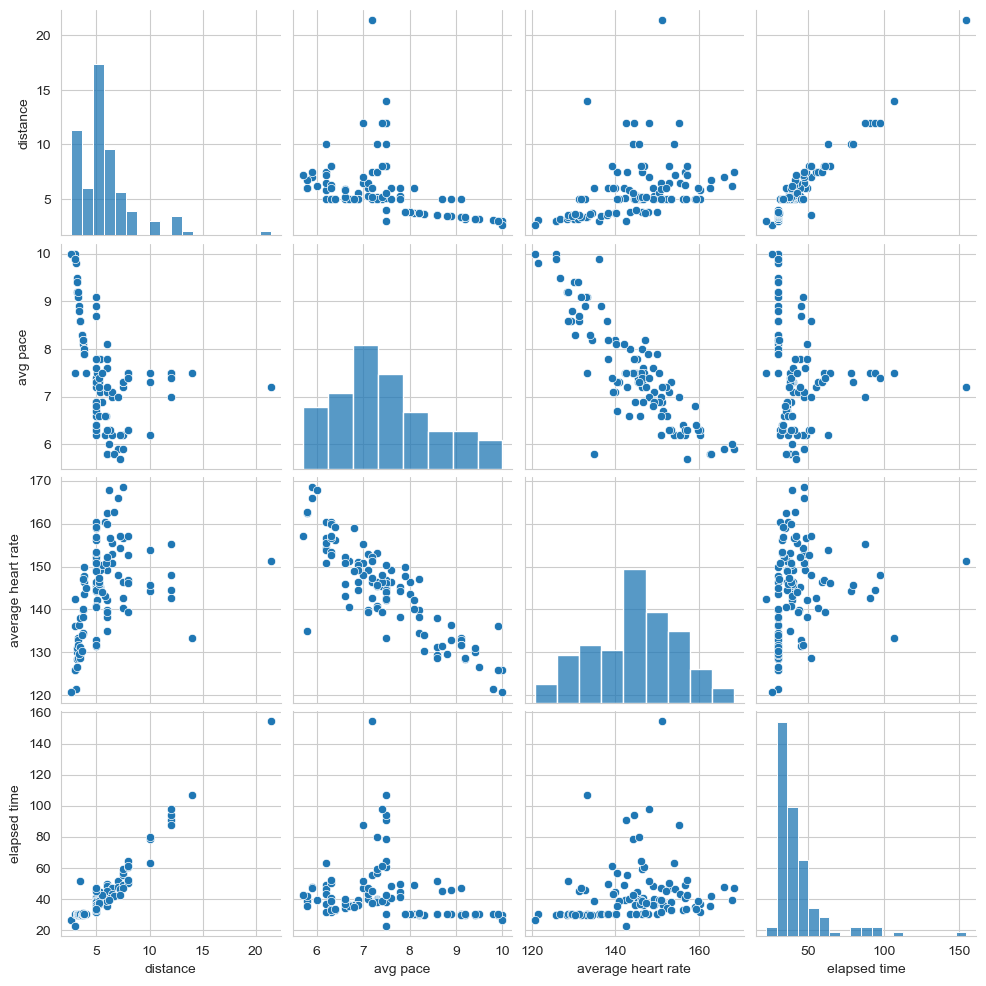

In [583]:
# Let's create a pairs plot using the seaborn library to identify trends. I picked only few varabiales so that it won't get messy.
pp_runs = runs[['distance', 'avg pace', 'average heart rate', 'elapsed time']]
sns.pairplot(pp_runs)

- There is a negative correlation between heart rate and pace - faster paces are linked to higher average heart rates.
- A noticeable trend where the longer the distance, the longer the elapsed time. 
- Histograms on the diagonal show that distance and elapsed time are right-skewed (most runs are shorter), while average pace and heart rate appear more normally distributed. 

## How did the total distance change throughout the year?

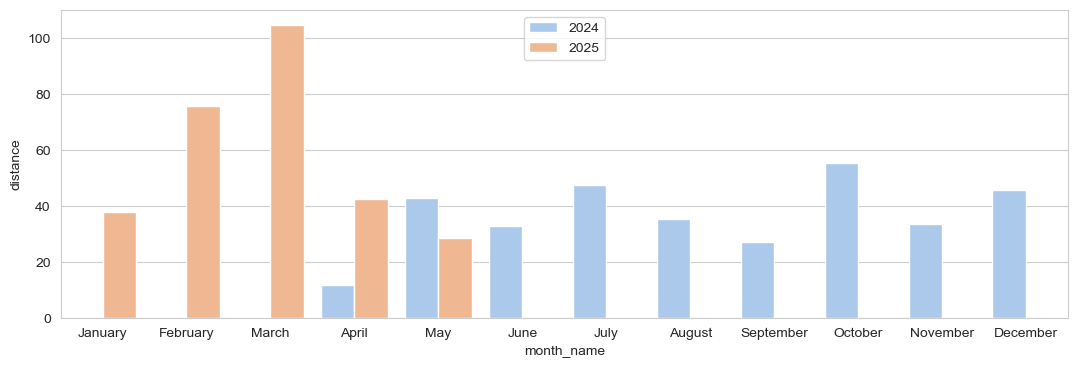

In [586]:
# Let's create a bar plot using seaborn library to see how the distance changed throughout the year
sns.set_style('whitegrid')
sns.barplot(x='month_name', y='distance', data=runs, hue='year', errorbar=None, estimator=np.sum, palette = "pastel",
           order =["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
plt.gcf().set_size_inches(13, 4)
plt.legend(loc='upper center')

- In April the total distance is really small comparing to other months, but the first entry in the dataset is from end of April. 
- It seems that the distance I ran in March 2025 was the highest of all months - 100+ km.
- The mileage in early 2025 compared to 2024 significantly increased. If this trend contiunes, 2025 might result in a much higher overall distance than 2024.

## Have the average pace improved over time?

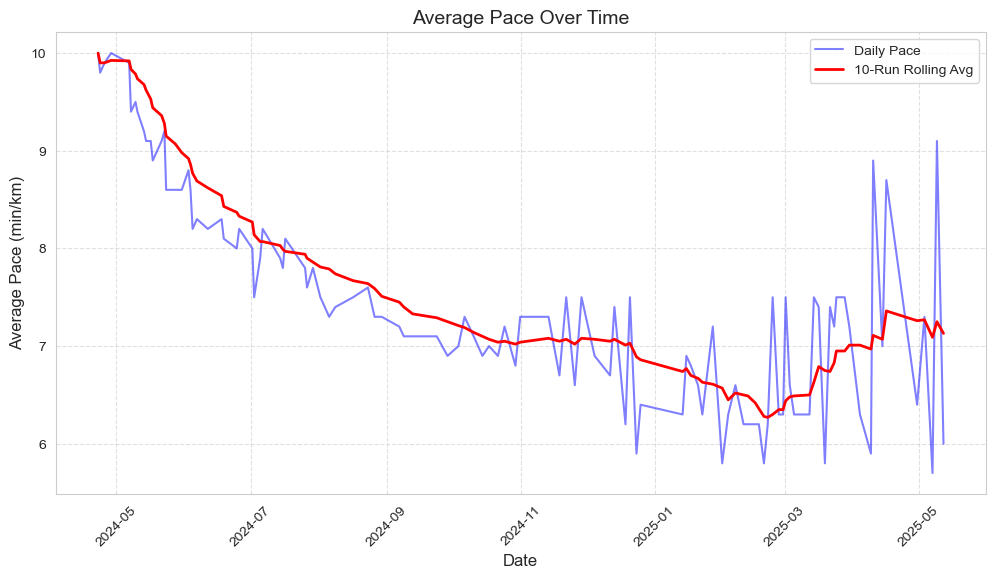

In [589]:
# Sort by date
runs = runs.sort_values(by='activity date')

# Calculate a rolling average
runs['rolling_avg_pace'] = runs['avg pace'].rolling(window=10, min_periods=1).mean()

# Creating the plot and formatting
plt.figure(figsize=(12, 6))
sns.lineplot(data=runs, x='activity date', y='avg pace', label='Daily Pace', color='blue', alpha=0.5)
sns.lineplot(data=runs, x='activity date', y='rolling_avg_pace', label='10-Run Rolling Avg', color='red', linewidth=2)

plt.title("Average Pace Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Pace (min/km)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

Blue Line represents the daily average pace, which fluctuates due to different training sessions.
Red Line shows the smoothed rolling average, helping to visualize long-term improvement.

Conclusion: the time series plot shows a significant improvements in the average running pace over time, particularly from May 2024 to early 2025.
The average pace declines from over 10 min/km to around 7 min/km. The cause may be regular training and building endurance.

Between March and May 2025, a slight increase in rolling average is visible. This may indicate a higher amount of longer and slower runs. This in fact is true because at that time I was preparing myself for a Half Marathon competition, which required performing longer runs. Additionally, I introduced zone 2 runs (a low-intensity workout where the heart rate stays at 60-70% of its maximum).